In [788]:
import torch
import torchaudio
import torchvision
import os
import random
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch import cuda
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image

from PIL import Image
from pathlib import Path

In [789]:
device = "cuda:0" if cuda.is_available() else "cpu"
device 

'cuda:0'

In [790]:
%store -r class_num

In [791]:
%store -r class_weights
weights = torch.from_numpy(class_weights).float().to(device=device)

%store -r path_train_dataloader_batched
%store -r path_test_dataloader_batched
%store -r path_val_dataloader_batched
train_dataloader = torch.load(path_train_dataloader_batched)
test_dataloader = torch.load(path_test_dataloader_batched)
val_dataloader = torch.load(path_val_dataloader_batched)

In [792]:
weights

tensor([0.8732, 2.0354, 0.8732, 0.8732, 0.8732, 0.8732, 2.3348, 0.8732, 0.9399,
        0.8732], device='cuda:0')

3.A) Create a CNN model

In [793]:
class CNN(nn.Module):
    def __init__(self, in_units: int, hidden_units: int, out_units: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
        self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
        )
        
        self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*2*29*29,
                  out_features=out_units)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [794]:
model = CNN(in_units=1,
            hidden_units=32,
            out_units=class_num).to(device)

In [795]:
next(model.parameters()).device

device(type='cuda', index=0)

In [796]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([8, 1, 128, 128]), torch.Size([8]))

torch.Size([1, 128, 128])

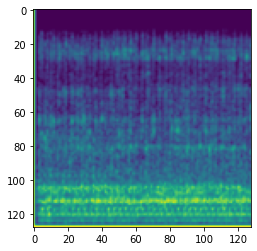

In [797]:
plt.imshow(X[0].permute(1,2,0))
X[0].shape

In [798]:
logit = model(X.to(device))

In [799]:
logit[3].argmax(), y[3]

(tensor(7, device='cuda:0'), tensor(8))

In [800]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 1, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 62, 62]           --
│    └─Conv2d: 2-1                       [1, 32, 126, 126]         320
│    └─ReLU: 2-2                         [1, 32, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 64, 124, 124]         18,496
│    └─ReLU: 2-4                         [1, 64, 124, 124]         --
│    └─MaxPool2d: 2-5                    [1, 64, 62, 62]           --
├─Sequential: 1-2                        [1, 64, 29, 29]           --
│    └─Conv2d: 2-6                       [1, 64, 60, 60]           36,928
│    └─ReLU: 2-7                         [1, 64, 60, 60]           --
│    └─Conv2d: 2-8                       [1, 64, 58, 58]           36,928
│    └─ReLU: 2-9                         [1, 64, 58, 58]           --
│    └─MaxPool2d: 2-10                   [1, 64, 29, 29]           --
├─

3.B) Train the MODEL using the dataset

In [801]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [802]:
def valid_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):

    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer

    for data, labels in dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = loss_fn(target,labels)
        valid_loss += loss.item()
        
    return valid_loss / len(val_dataloader)

In [803]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [804]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5, 
          device=device):
  
  # 2. empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop  training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    valid_loss = valid_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print 
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Validation Loss: {valid_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(valid_loss)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return results
  return results

In [805]:
# Free up the GPU cache in case of training model on your PC.
import gc

gc.collect()

torch.cuda.empty_cache()

In [806]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# loss function and optimizer 
loss_fn = nn.CrossEntropyLoss(weight=weights) 
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0015)

# Start timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3833 | Train acc: 0.5179 | Validation Loss: 1.0049 | Test loss: 0.9575 | Test acc: 0.6583
Epoch: 1 | Train loss: 0.8369 | Train acc: 0.7133 | Validation Loss: 0.7369 | Test loss: 0.7316 | Test acc: 0.7563
Epoch: 2 | Train loss: 0.5506 | Train acc: 0.8113 | Validation Loss: 0.7522 | Test loss: 0.7110 | Test acc: 0.7683
Epoch: 3 | Train loss: 0.3451 | Train acc: 0.8834 | Validation Loss: 0.7610 | Test loss: 0.7765 | Test acc: 0.7768
Epoch: 4 | Train loss: 0.2085 | Train acc: 0.9293 | Validation Loss: 0.9288 | Test loss: 0.8902 | Test acc: 0.7808
Total training time: 813.430 seconds


3.C ) Metrics are printed above and ACCURACY and LOSS graphs are shown below

In [807]:
def plot_loss_curves(results: dict[str, list[float]]):
  """Plots training curves of a results dictionary."""

  loss = results["train_loss"]
  test_loss = results["test_loss"]

 
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

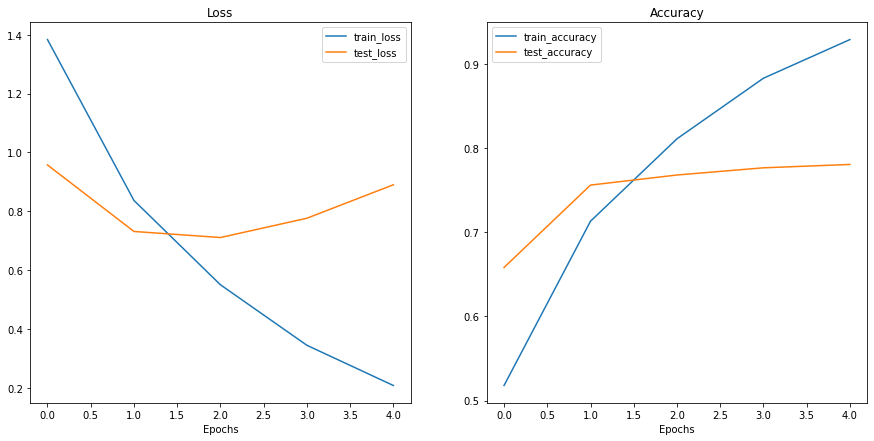

In [809]:
plot_loss_curves(model_results) 

3.D ) Learning rate, hidden unit number and other hyperparameters were optimized and model reached %93 percent accuracy. 

In [ ]:
model.state_dict()